In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import selfies as sf
import mutations as mut
from functools import partial
import metrics as met
import functions as fn
from constants import *
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
import pandas as pd
from datetime import datetime
import time
from tqdm import tqdm
from guacamol import standard_benchmarks
import numpy as np
import random
from copy import copy
import crossovers as xo

c:\Users\marti\anaconda3\envs\thesis_3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED_SIZE_LIST = [10, 100, 1000, 10000, 100000]
SEED_SIZE = SEED_SIZE_LIST[1]
SEED_LIST = [0,1,2]
SEED = SEED_LIST[2]
BUDGET_LIST = [100, 1000, 10000, 100000]
BUDGET = BUDGET_LIST[2]
GENERATIONS = 50




SAVE = True

# Single metric optimization

In [4]:
#f = standard_benchmarks.zaleplon_with_other_formula().objective.score_list()
celecoxib = 'O=S(=O)(c3ccc(n1nc(cc1c2ccc(cc2)C)C(F)(F)F)cc3)N'
troglitazone = 'O=C1NC(=O)SC1Cc4ccc(OCC3(Oc2c(c(c(O)c(c2CC3)C)C)C)C)cc4'
metric_function_list = [
    #partial(standard_benchmarks.median_tadalafil_sildenafil().objective.score_list)
    partial(met.compound_similarity,target_smile = troglitazone)
]
metrics = ['Metric 1']

In [5]:
mutation_function_list = [
    partial(mut.replacement,n=1 ,ring_aware= False)
    ,partial(mut.addition,fragment_size=1,rings=False)
    ,partial(mut.deletion,n=1)
]

In [151]:
current_dateTime = datetime.now()
time_format = f"{current_dateTime.date()}_{str(current_dateTime.hour).zfill(2)}-{str(current_dateTime.minute).zfill(2)}-{str(current_dateTime.second).zfill(2)}"
chem_lookup = {}
for SEED in [SEED_LIST[0]]:#SEED_LIST[1:]:
    for SEED_SIZE in [SEED_SIZE_LIST[2]]:#SEED_SIZE_LIST[1:]:#[SEED_SIZE_LIST[1]]:#
        SEED_PATH = f"../data/seed_{SEED}/rand_{SEED_SIZE}.tsv"
        seed_df = pd.read_table(SEED_PATH) 
        print(f"=== len chem lookup {len(chem_lookup)}")
        initial_pop, _, chem_lookup = fn.convert_seeds_to_df(seed_df,metric_function_list)
        print(f"=== len chem lookup {len(chem_lookup)}")
        #chem_lookup.update(initial_pop.set_index('SMILES molecule')['Metric 1'].to_dict()) #canon and set
        for BUDGET in [BUDGET_LIST[2]]:#BUDGET_LIST[:4]:#BUDGET_LIST[:4]#
            setup_name = f"seed_{SEED}_rand_{SEED_SIZE}"
            file_name = f"{time_format}_{setup_name}_budget_{BUDGET}"
            B0 = copy(BUDGET)
            generation = 0
            t0 = time.time()
            
            first_generation_fraction = 0.05 #hyperparam
            N = int(BUDGET * first_generation_fraction) #1st generation size

            if len(initial_pop)>=N:
                initial_best = initial_pop.head(N)
            else:
                initial_best = initial_pop
            gen_history = pd.DataFrame(initial_best)
            temp_best = initial_best.copy(deep=True)
            cost_history = []

            #rest of hyperparams
            crossover = True
            crossover_ratio = 0.2

            next_generation_fraction = 0.05 #size of next generation; BUDGET * next_generation_fraction = new N
            initial_sample_fraction = 0.5 #initial_sample_size = len(temp_best) *  initial_sample_fraction ))
            minimal_next_generation_fraction = 0.0025
            max_gens = 500
            percent_best_fraction = 0.15 #CHANGED FITNESS ADJUSTMENT TO 0.05 FROM 0.1
            include_initial_pop = False





            pbar = tqdm(desc=f"Working with budget of {B0}",
                        total=B0)
            while (BUDGET > len(temp_best)):
                #percentage_done = round(np.floor((B0-BUDGET)/B0*1000)/10,2)
                #print(f"{percentage_done}% done")
                diversity = fn.get_last_diversity(temp_best)
                homogenity = 1 - diversity

                #crossover_ratio =  0.1#0.01 + ((diversity)/10)
                #print(f'crossover_ratio = {crossover_ratio}, N={N}')
                if diversity<0.75:
                    mutation_function_list = [
                        partial(mut.replacement,n=3,random_size=True,ring_aware= False)
                        ,partial(mut.addition,fragment_size=3,random_size=True,rings=False)
                        ,partial(mut.deletion,n=3,random_size=True)
                    ]
                elif diversity>0.8:
                    mutation_function_list = [
                        partial(mut.replacement,n=1 ,ring_aware= False)
                        ,partial(mut.addition,fragment_size=1,rings=False)
                        ,partial(mut.deletion,n=1)
                    ]



                temp_pop, cost, chem_lookup = fn.populate_from_df(temp_best,N,metric_function_list,mutation_function_list,
                                            generation+1,include_seeds=True,fitness='Metric 1',crossover=crossover, crossover_type=0,
                                            crossover_ratio=crossover_ratio, fitness_proportional = True, lookup_dict=copy(chem_lookup))
                cost_history.append(cost)
                BUDGET -= cost
                temp_pop.reset_index(drop=True,inplace=True)


                #if homogenity>0:
                #    temp_best = fn.get_percent_best(temp_pop, metrics,0.05+((homogenity**2)/2),minimize=False)
                #else:
                temp_best = fn.get_percent_best(temp_pop, metrics,percent_best_fraction,minimize=False)
                gen_history = pd.concat([gen_history,temp_best])
                
                
                
                if include_initial_pop:
                    initial_sample_size = int(np.ceil(  len(temp_best) *  initial_sample_fraction   ))
                    #initial_sample_size = 3 * int(np.ceil( len(temp_best)* homogenity**2  ))
                    #if initial_sample_size>len(initial_pop):
                    #    initial_sample_size = len(initial_pop)

                    temp_best = pd.concat([temp_best, initial_pop.sample(initial_sample_size)])
                
                

            
                #if homogenity==0:
                N = int(np.ceil(BUDGET * next_generation_fraction))
                    #print(f"homo {homogenity} , N {N}")
                #else:
                #    N = int(np.ceil(BUDGET * 0.1  * homogenity))
                    #print(f"no homo N {N}")
                #print(f"------- {N} ------- BUDGET / GENERATIONS {BUDGET / GENERATIONS} * homogenity {homogenity} + 0.1  = {(BUDGET / GENERATIONS) * homogenity + 0.1}")
                if N<=int(np.ceil(minimal_next_generation_fraction*B0)):
                    N = int(np.ceil(minimal_next_generation_fraction*B0))
                pbar.update(cost)
                generation += 1
                if generation>=max_gens:
                    break
            pbar.update(BUDGET)
            pbar.close()
            print(f"Done in {time.time()-t0}")
            if SAVE:
                gen_history.to_csv("out_exp/"+file_name+".csv")

###
latest_gen = gen_history[gen_history['Generation']==gen_history['Generation'].max()]
latest_gen.head()

=== len chem lookup 0
=== len chem lookup 1000


Working with budget of 10000: 100%|██████████| 10000/10000 [01:44<00:00, 96.05it/s]

Done in 104.11834406852722


,SMILES molecule,Generation,Metric 1
16,C([O+]=C[N+]CS[C-](CC1=C2C=C(C3OC(CCC1=3)(C)CO...,101,0.772598
23,CC[O+]=C[N+]CS[C-](C=[O+]C)CC1=C2OCC3(C)OC(=C1...,101,0.765478
22,C1C2(C)OC3C(=CC(OC2)=C(C[C-](C=[O+]C)SC[N+]C=[...,101,0.765478
21,C(C)[O+]=C[N+]CS[C-](C=[O+]C)CC1C2=C3OC(C)(COC...,101,0.765478


In [152]:
float(latest_gen.head(1)['Metric 1'])

0.7725975261655567

In [153]:
print(len(chem_lookup))

11015


Best score


<Axes: >

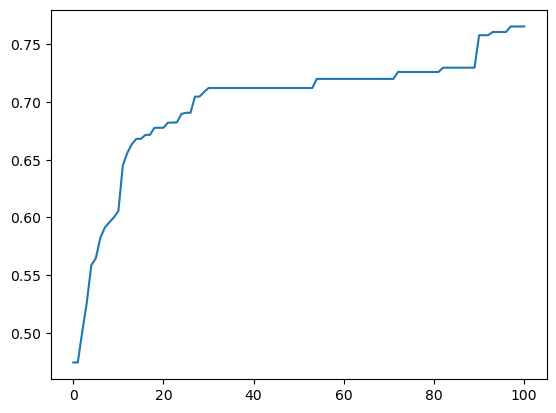

In [154]:
dayta = [np.max(gen_history[gen_history['Generation']==i]['Metric 1']) for i in range(0,gen_history['Generation'].max())]
sns.lineplot(dayta)

Diversity

<Axes: >

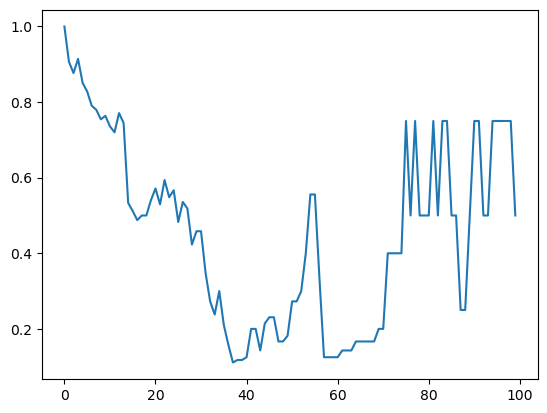

In [155]:
dayta = [len(pd.unique(gen_history[gen_history['Generation']==i]['SMILES molecule'].apply(lambda x: fn.canonicalize_smile(x))))/len((gen_history[gen_history['Generation']==i]['SMILES molecule'])) for i in range(1,gen_history['Generation'].max())]
sns.lineplot(dayta)

# BEST size

<Axes: >

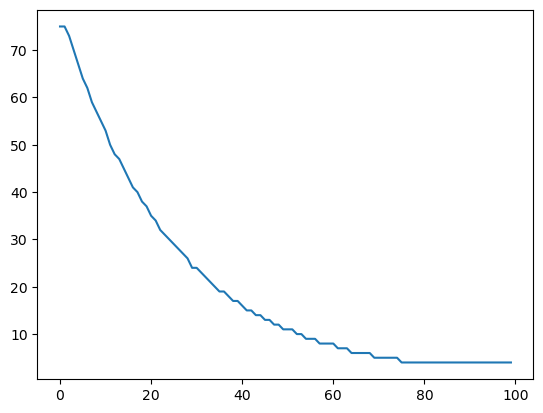

In [156]:
dayta = [len((gen_history[gen_history['Generation']==i]['SMILES molecule'])) for i in range(1,gen_history['Generation'].max())]
sns.lineplot(dayta)

<Axes: >

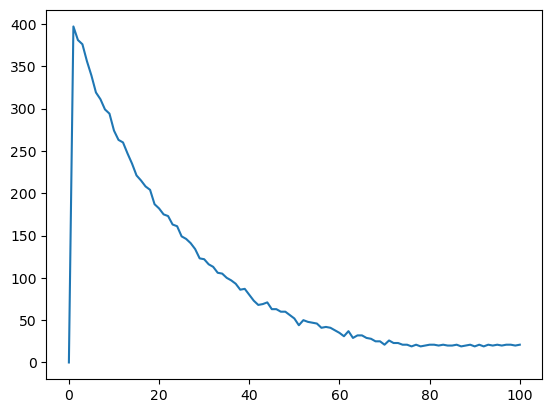

In [157]:
sns.lineplot(cost_history)

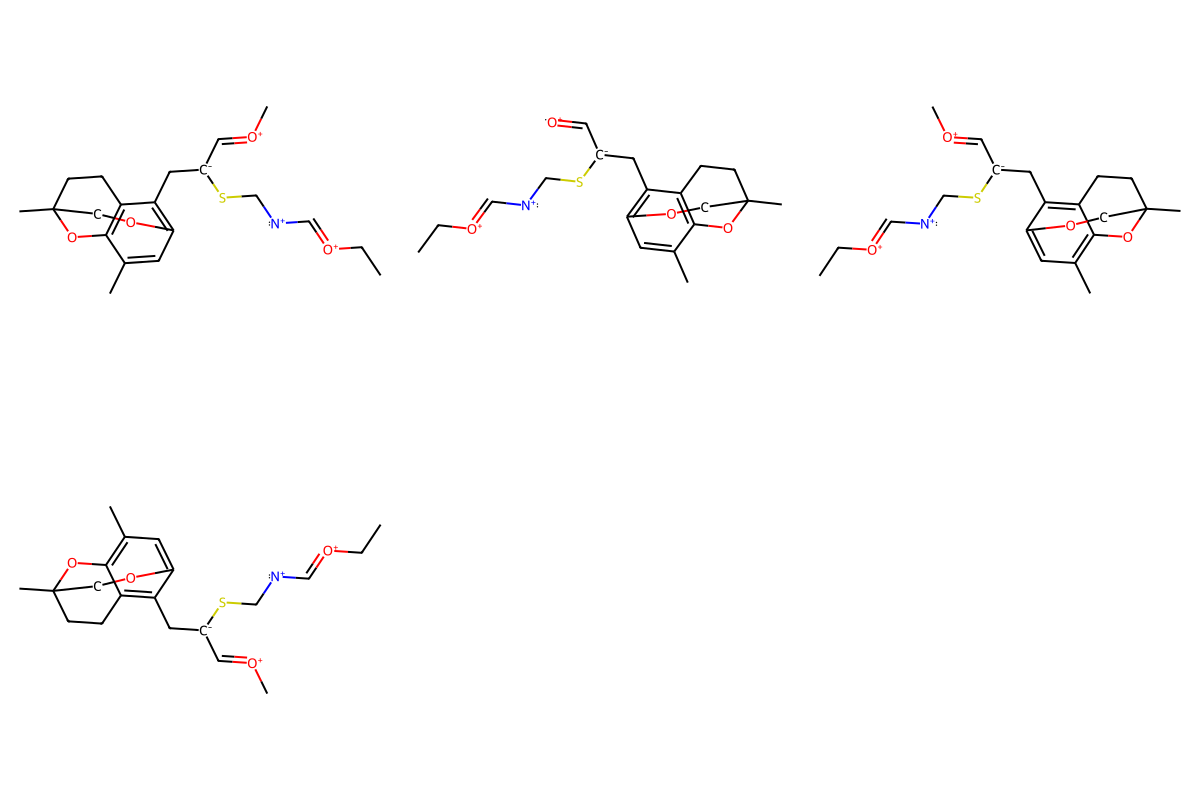

In [158]:
latest_gen_mol = [Chem.MolFromSmiles(molecule) for molecule in set(latest_gen["SMILES molecule"][:6])]
img = Draw.MolsToGridImage(latest_gen_mol, 
                           molsPerRow=3,
                           subImgSize=(400, 400), 
                           maxMols=len(latest_gen),
                           legends=None)
display(img)

In [134]:
plot_metric_generations = False
if plot_metric_generations:
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import norm


    generations = gen_history['Generation'].unique()
    generations.sort()  # Make sure generations are sorted

    pal = sns.cubehelix_palette(len(generations), rot=-.25, light=.7)

    # Initialize a FacetGrid object
    g = sns.FacetGrid(gen_history, row="Generation", hue="Generation", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Metric 1", clip_on=False, shade=True, alpha=1, lw=1.5, bw_method=.2)
    #g.map(sns.kdeplot, "Metric 1", clip_on=False, color="w", lw=2, bw_method=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "Metric 1")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.0)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.xlabel('Zaleplon similarity ', fontsize=14)
    plt.ylabel('Generation', fontsize=14)

    plt.show()
